Grundlegender Aufbau:
Imports
Aufgabe 5

In [2]:
import Lab3Functions as lf3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, hilbert
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [9]:
weights, mvc, fatigue = lf3.import_data(';')

print(fatigue)

        emg      t
0      1499   1618
1      1499   1620
2      1499   1623
3      1499   1626
4      1500   1628
...     ...    ...
20811  1462  53340
20812  1467  53343
20813  1473  53345
20814  1481  53348
20815  1492  53350

[20816 rows x 2 columns]


In [4]:
def remove_offset(emg):
    """Entfernt Mittel um Offset zu eliminieren"""
    return emg - np.mean(emg)

def bandpass_filter(emg, lowcut, highcut, fs, order=4):
    """
    Nutzt Butterworth Filter um nur Frequenzen zwischen lowcut und highcut zu behalten
    In unserem Fall zw. 20 und 450 Herz
    """
    nyquist = 0.5 * fs  # Nyquist-Frequenz = halbe Sampling-Frequenz
    low = lowcut / nyquist  # Normierte untere Grenzfrequenz
    high = highcut / nyquist  # Normierte obere Grenzfrequenz
    b, a = butter(order, [low, high], btype='band')  # Butterworth-Bandpassfilter
    return filtfilt(b, a, emg)  # Signal filtern (vorwärts und rückwärts für Null-Phasenverschiebung)

def rectify_signal(emg):
    """Wandelt alle negativen Werte in positive um"""
    return np.abs(emg)

def calculate_envelope(emg, fs, cutoff=3, order=2):
    """Durch Hilbert-Transformation - Hüllkurve des EMG-Signals, Tiefpass glättet, 3Hz aus Angabe"""
    nyquist = 0.5 * fs  # Nyquist-Frequenz
    low = cutoff / nyquist  # Normierte Grenzfrequenz des Lowpass-Filters
    b, a = butter(order, low, btype='low')  # Butterworth-Tiefpassfilter
    analytic_signal = hilbert(emg)  # Hilbert-Transformation, um die Hüllkurve zu extrahieren
    envelope = np.abs(analytic_signal)  # Betrag des analytischen Signals
    return filtfilt(b, a, envelope)  # Glätten der Hüllkurve

def process_emg(data, fs):
    """
    Funktion welche die EMG-Daten verarbeitet
    Input: data (DataFrame mit 't' und 'emg' Spalten), fs (Sampling-Frequenz)
    Output: DataFrame mit 't', 'emg_filtered', 'emg_rectified', 'emg_envelope' Spalten
    """
    # Schritt a: Offset eliminieren
    emg_no_offset = remove_offset(data['emg'])
    # Schritt b: Bandpass-Filterung (20-450 Hz)
    emg_filtered = bandpass_filter(emg_no_offset, 20, 190, fs)
    # Schritt c: Signal gleichrichten
    emg_rectified = rectify_signal(emg_filtered)
    # Schritt d: Hüllkurve bilden
    emg_envelope = calculate_envelope(emg_filtered, fs)
    
    # Zusammenfassen der Ergebnisse in einem neuen DataFrame
    result = pd.DataFrame({
        't': data['t'],  # Zeit bleibt unverändert
        'emg_no_offset': emg_no_offset,  # EMG ohne Offset
        'emg_filtered': emg_filtered,  # Gefiltertes EMG
        'emg_rectified': emg_rectified,  # Gleichgerichtetes Signal
        'emg_envelope': emg_envelope  # Hüllkurve
    })
    return result

# Basierend auf den vorliegenden Daten (Sampling-Periode von ~2.43 ms).
sampling_frequency = 411.76  # Hz

# Daten verarbeiten
mvc_processed = process_emg(mvc, sampling_frequency)

# Erstelle Subplots mit jeweils 2 Plots nebeneinander pro Zeile
fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=[
        "Original EMG", "Mean-Corrected EMG",
        "Unfiltered EMG", "Filtered EMG",
        "Unrectified EMG", "Rectified EMG",
        "Rectified EMG", "Envelope"
    ]
)

# Original vs. Mean-Corrected
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc['emg'], mode='lines', name="Original EMG"), row=1, col=1)
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_no_offset'], mode='lines', name="Mean-Corrected EMG"), row=1, col=2)

# Unfiltered vs. Filtered
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_no_offset'], mode='lines', name="Unfiltered EMG"), row=2, col=1)
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_filtered'], mode='lines', name="Filtered EMG"), row=2, col=2)

# Unrectified vs. Rectified
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_filtered'], mode='lines', name="Unrectified EMG"), row=3, col=1)
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_rectified'], mode='lines', name="Rectified EMG"), row=3, col=2)

# Rectified vs. Envelope
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_rectified'], mode='lines', name="Rectified EMG"), row=4, col=1)
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_envelope'], mode='lines', name="Envelope"), row=4, col=2)

# Layout anpassen
fig.update_layout(
    title="Comparison of MVC Processing Steps",
    height=1200,  # Gesamthöhe des Plots
    width=1000,  # Gesamtbreite des Plots
    font=dict(size=14),  # Schriftgröße
    title_font=dict(size=18),  # Schriftgröße für den Titel
    showlegend=False,  # Legende nicht anzeigen
    template="plotly_white",
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
# Y-Achsen individuell beschriften
fig.update_yaxes(title="Original EMG", row=1, col=1)
fig.update_yaxes(title="Mean-Corrected EMG", row=1, col=2)
fig.update_yaxes(title="Unfiltered EMG", row=2, col=1)
fig.update_yaxes(title="Filtered EMG", row=2, col=2)
fig.update_yaxes(title="Unrectified EMG", row=3, col=1)
fig.update_yaxes(title="Rectified EMG", row=3, col=2)
fig.update_yaxes(title="Rectified EMG", row=4, col=1)
fig.update_yaxes(title="Envelope", row=4, col=2)

# Plots anzeigen
fig.show()


In [11]:
# Daten verarbeiten
mvc_processed = process_emg(mvc, sampling_frequency)
weights_processed = process_emg(weights, sampling_frequency)
fatigue_processed = process_emg(fatigue, sampling_frequency)

#mvc_s,mvc_e,weights_s,weights_e,fatigues,fatiguee = lf3.get_bursts(mvc_processed['emg_filtered'],weights_processed['emg_filtered'],weights_processed['emg_filtered'])

Aufgabe 8

Aufgabe 9 


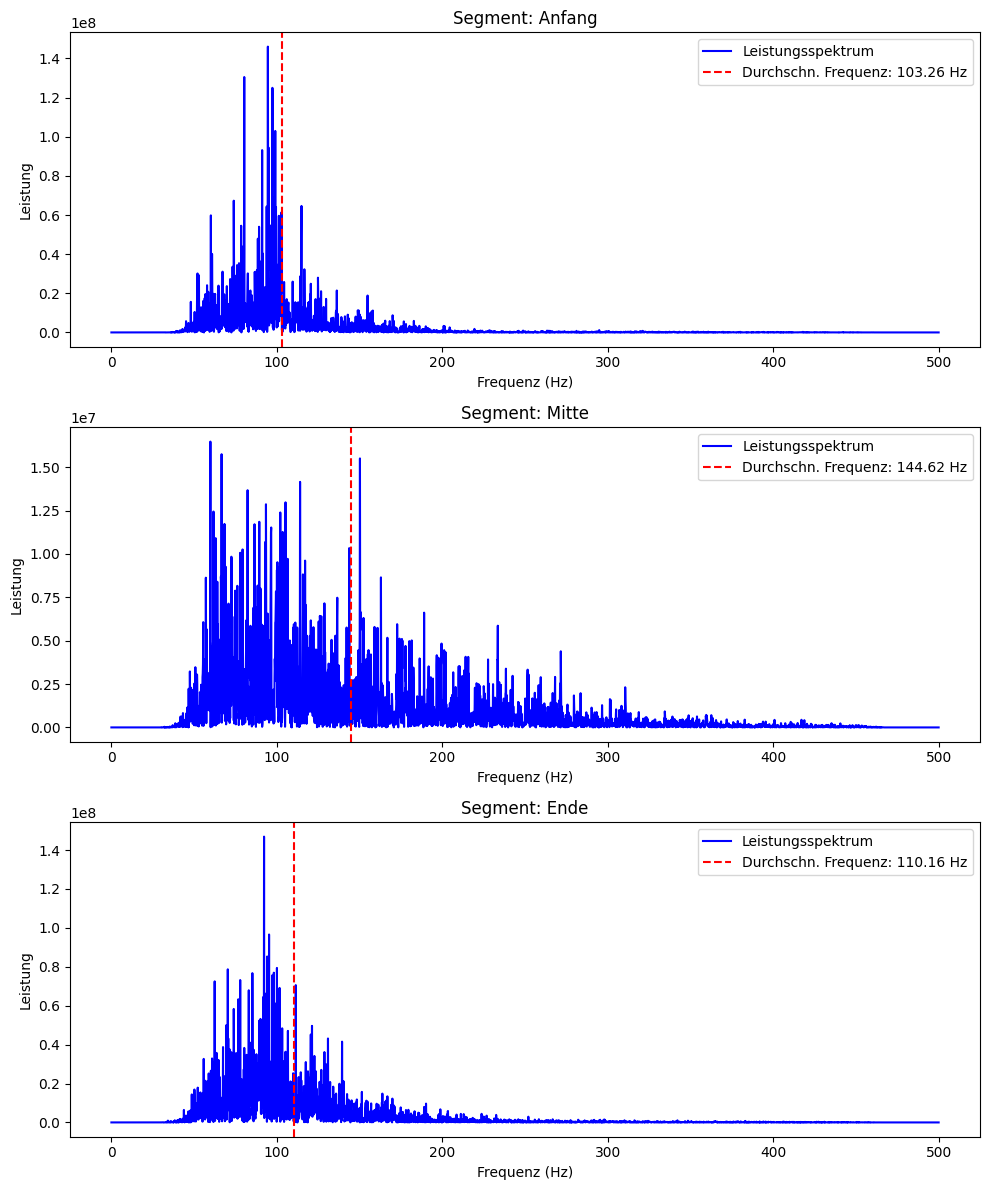

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Funktion zur Berechnung des Leistungsspektrums
def compute_power_spectrum(data, fs):
    n = len(data)
    freqs = fftfreq(n, 1/fs)[:n//2]
    fft_vals = fft(data)
    power = np.abs(fft_vals[:n//2])**2
    return freqs, power

# Funktion zur Berechnung der durchschnittlichen Frequenz
def compute_avg_frequency(freqs, power):
    return np.sum(freqs * power) / np.sum(power)

# Sampling-Frequenz und prozessierte Daten aus fatigue_processed
fs = 1000  # Beispiel: Sampling-Frequenz in Hz
fatigue_data = fatigue_processed["emg_filtered"]

# Segmentierung in Anfang, Mitte und Ende
n_samples = len(fatigue_data)
segments = {
    "Anfang": fatigue_data[:n_samples // 3],
    "Mitte": fatigue_data[n_samples // 3: 2 * n_samples // 3],
    "Ende": fatigue_data[2 * n_samples // 3:]
}

# Visualisierung
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
for i, (segment_name, data_segment) in enumerate(segments.items()):
    # Leistungsspektrum berechnen
    freqs, power = compute_power_spectrum(data_segment, fs)

    # Durchschnittliche Frequenz berechnen
    avg_freq = compute_avg_frequency(freqs, power)

    # Plot
    ax[i].plot(freqs, power, label="Leistungsspektrum", color="blue")
    ax[i].axvline(avg_freq, color="red", linestyle="--", label=f"Durchschn. Frequenz: {avg_freq:.2f} Hz")
    ax[i].set_title(f"Segment: {segment_name}")
    ax[i].set_xlabel("Frequenz (Hz)")
    ax[i].set_ylabel("Leistung")
    ax[i].legend()

plt.tight_layout()
plt.show()
